## Import libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dropout, Flatten, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import vgg16, Xception
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split
import pickle

## Load data

In [10]:
data_gen = ImageDataGenerator(rescale=1./255)

data_gen = data_gen.flow_from_directory(
    directory='Data/train/', 
    target_size=(224, 224),
    batch_size=5232
)

X = data_gen[0][0]
y = data_gen[0][1]

Found 5232 images belonging to 2 classes.


## Visualize data

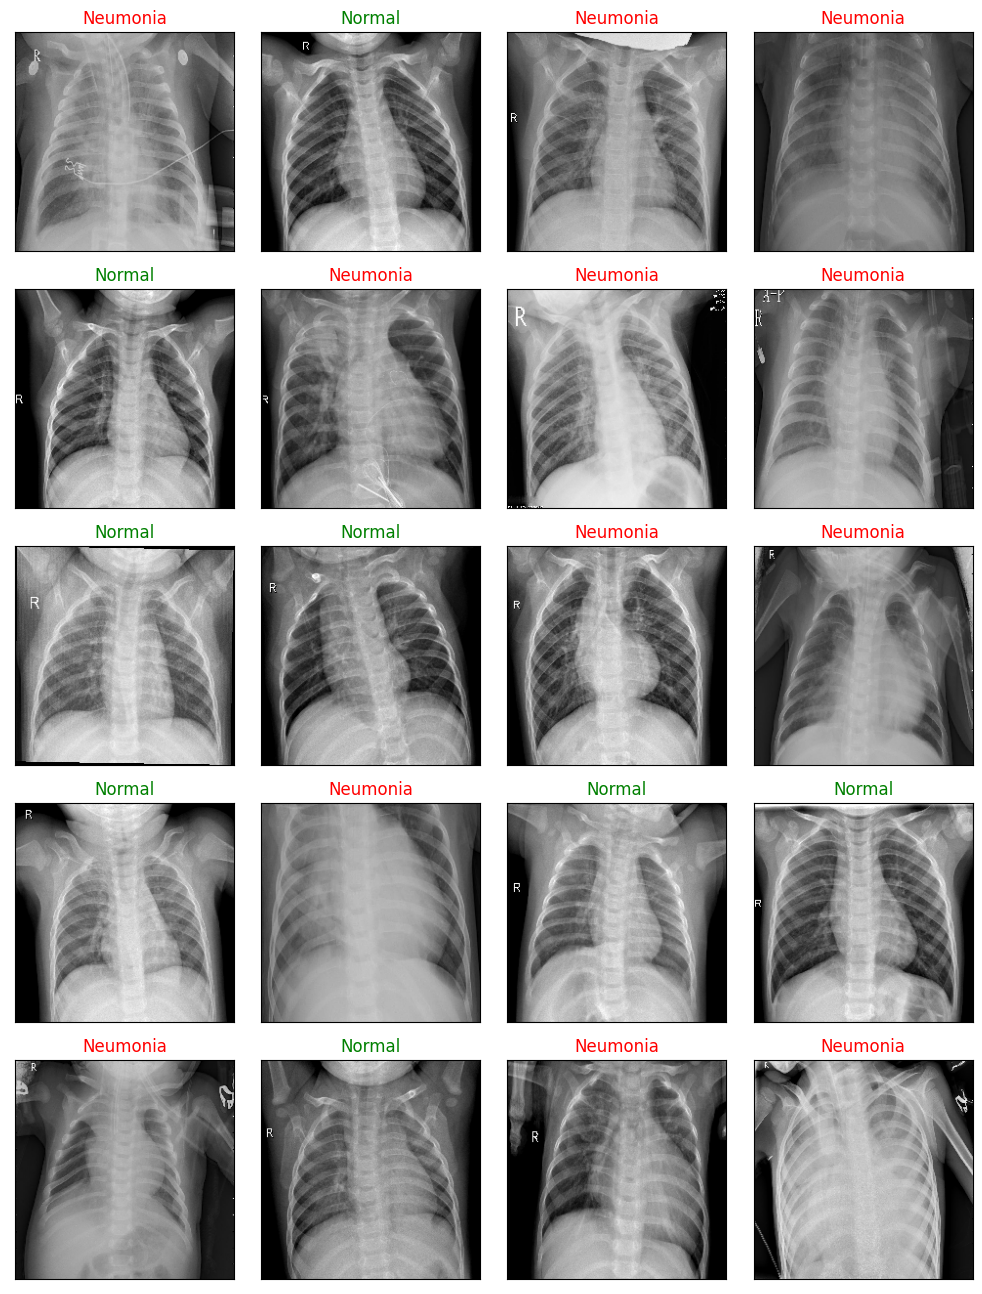

In [31]:
fig, axs = plt.subplots(5, 4, figsize=(10, 13))

for i, ax in enumerate(axs.flat):
    ax.imshow(x[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Normal" if y[i,0] == 1 else "Neumonia" ,
                 color='green' if y[i,0] == 1 else 'red', 
                 fontsize=12)
plt.tight_layout()
plt.show()

## Model VGG16

In [3]:
vgg16 = vgg16.VGG16()

In [4]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Extract convolutional layers

In [5]:
model_vgg16 = Sequential()
for i in range(19):
    model_vgg16.add(vgg16.get_layer(index=i))

In [6]:
model_vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

## Extract image features with vgg16 model

In [29]:
X_vgg16 = model_vgg16.predict(X)

164/164 [==============================] - 1461s 9s/step


In [31]:
with open("Data/data_vgg16_train.pickle", "wb") as f:
    pickle.dump({'x':X_vgg16, 'y':y}, f)

## Load processed data

In [3]:
with open("Data/data_vgg16_train.pickle", "rb") as f:
    data = pickle.load(f)

In [6]:
x = data['x']
y = data['y']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

In [18]:
print('Input size: ', x.shape)
print('Target size: ', y.shape)

Input size:  (5232, 7, 7, 512)
Target size:  (5232, 2)


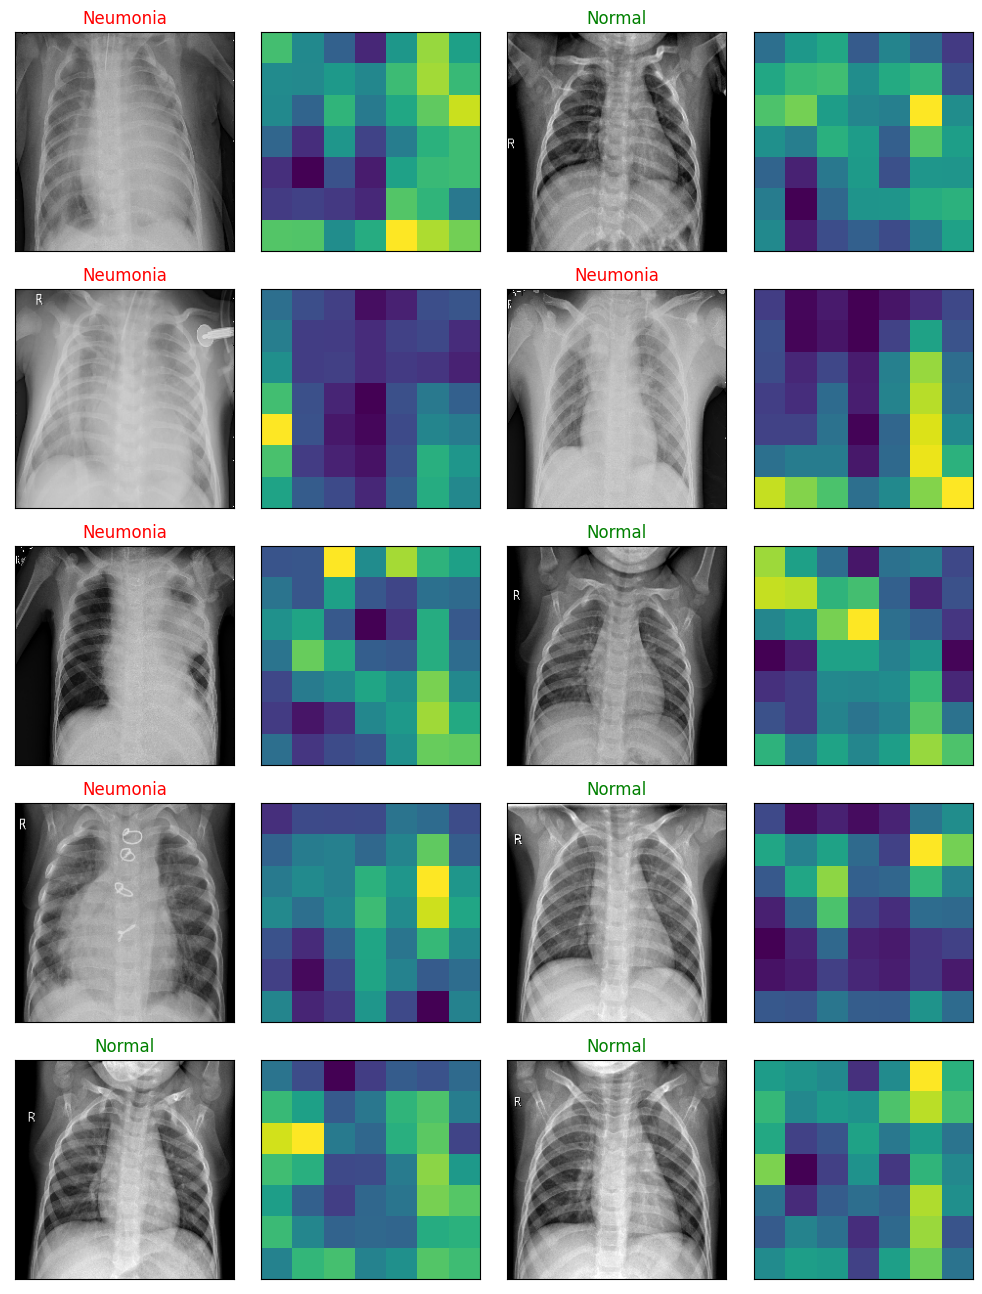

In [15]:
fig, axs = plt.subplots(5, 4, figsize=(10, 13))

for i, ax in enumerate(axs.flat):
    if i%2 == 0:
        ax.imshow(X[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title("Normal" if y[i,0] == 1 else "Neumonia" ,
                     color='green' if y[i,0] == 1 else 'red', 
                     fontsize=12)
    else:
        ax.imshow(np.sum(x[i-1], axis=2))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

In [57]:
model = Sequential()
model.add(Input(shape=(7,7,512)))
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=2, activation='softmax'))

In [58]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 7, 7, 16)          73744     
                                                                 
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_10 (Dense)            (None, 32)                25120     
                                                                 
 dense_11 (Dense)            (None, 2)                 66        
                                                                 
Total params: 98,930
Trainable params: 98,930
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.compile(loss='CategoricalCrossentropy', optimizer='Adam', metrics=['Accuracy'])
model.fit(X_, y_, epochs=16, batch_size=256, validation_split=0.2)

Epoch 1/16
17/17 [==============================] - 6s 236ms/step - loss: 0.2961 - Accuracy: 0.8669 - val_loss: 0.1267 - val_Accuracy: 0.9532
Epoch 2/16
17/17 [==============================] - 3s 162ms/step - loss: 0.1114 - Accuracy: 0.9579 - val_loss: 0.0929 - val_Accuracy: 0.9675
Epoch 3/16
17/17 [==============================] - 3s 189ms/step - loss: 0.0797 - Accuracy: 0.9730 - val_loss: 0.0659 - val_Accuracy: 0.9780
Epoch 4/16
17/17 [==============================] - 3s 153ms/step - loss: 0.0531 - Accuracy: 0.9833 - val_loss: 0.0535 - val_Accuracy: 0.9809
Epoch 5/16
17/17 [==============================] - 3s 152ms/step - loss: 0.0480 - Accuracy: 0.9830 - val_loss: 0.0511 - val_Accuracy: 0.9799
Epoch 6/16
17/17 [==============================] - 3s 150ms/step - loss: 0.0441 - Accuracy: 0.9852 - val_loss: 0.0465 - val_Accuracy: 0.9838
Epoch 7/16
17/17 [==============================] - 3s 152ms/step - loss: 0.0317 - Accuracy: 0.9914 - val_loss: 0.0469 - val_Accuracy: 0.9838
Epoch 

In [9]:
2%2

0